# Deep Neural Network for Breast Cancer Classification

In [ ]:
%pip install pandas==2.2.2
%pip install numpy==1.26.4
%pip install matplotlib==3.8.0
%pip install scikit-learn==1.5.0
%pip install torch==2.3.1
%pip install ucimlrepo==0.0.7

## Load the Data (Breast Cancer Wisconsin (Diagnostic))

In [7]:
from ucimlrepo import fetch_ucirepo 
  
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

display(X.head())
display(y.head())

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,Diagnosis
0,M
1,M
2,M
3,M
4,M


In [8]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
y['Diagnosis'].value_counts()

X shape: (569, 30)
y shape: (569, 1)


Diagnosis
B    357
M    212
Name: count, dtype: int64

In [9]:
import pandas as pd

data = pd.concat([X, y], axis=1)

data_B = data[data['Diagnosis'] == 'B']
data_M = data[data['Diagnosis'] == 'M']

data_B = data_B.sample(n=200, random_state=42)
data_M = data_M.sample(n=200, random_state=42)

balanced_data = pd.concat([data_B, data_M])

balanced_data['Diagnosis'].value_counts()

Diagnosis
B    200
M    200
Name: count, dtype: int64

## Data Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

X = balanced_data.drop('Diagnosis', axis=1)
y = balanced_data['Diagnosis']

y = y.map({'B': 0, 'M': 1})

y.head()

395    0
110    0
481    0
493    0
136    0
Name: Diagnosis, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Build and Train the Neural Network Model

In [13]:
import torch.nn as nn

class ClassificationNet(nn.Module):
    def __init__(self, input_units=30, hidden_units=64, output_units=2):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(input_units, hidden_units)
        self.fc2 = nn.Linear(hidden_units, output_units)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ClassificationNet(input_units=30, hidden_units=64, output_units=2)

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/10], Train Loss: 0.2930, Test Loss: 0.1743
Epoch [2/10], Train Loss: 0.1163, Test Loss: 0.1284
Epoch [3/10], Train Loss: 0.0882, Test Loss: 0.1184
Epoch [4/10], Train Loss: 0.0799, Test Loss: 0.1067
Epoch [5/10], Train Loss: 0.0701, Test Loss: 0.1035
Epoch [6/10], Train Loss: 0.0662, Test Loss: 0.0928
Epoch [7/10], Train Loss: 0.0602, Test Loss: 0.0981
Epoch [8/10], Train Loss: 0.0592, Test Loss: 0.0899
Epoch [9/10], Train Loss: 0.0525, Test Loss: 0.0897
Epoch [10/10], Train Loss: 0.0482, Test Loss: 0.0831


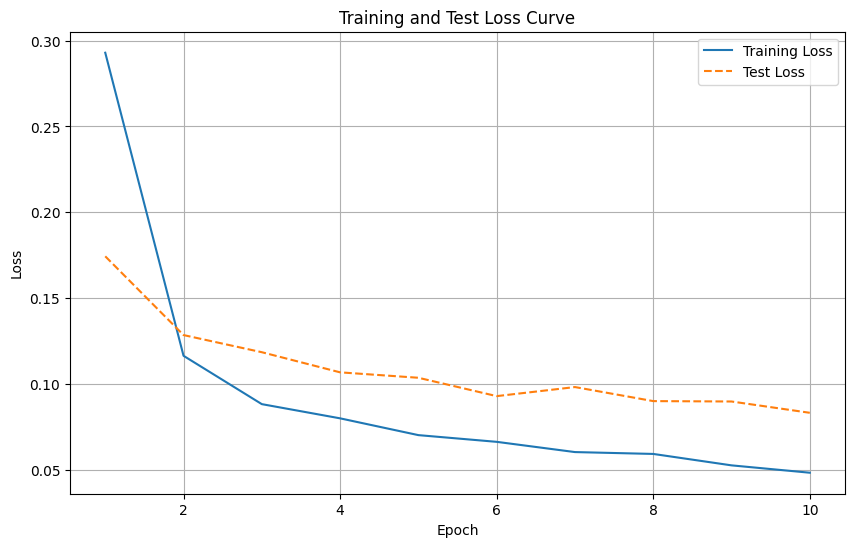

In [16]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## Change to SGD

Epoch [1/10], Train Loss: 0.3603, Test Loss: 0.2665
Epoch [2/10], Train Loss: 0.1846, Test Loss: 0.2049
Epoch [3/10], Train Loss: 0.1400, Test Loss: 0.1743
Epoch [4/10], Train Loss: 0.1176, Test Loss: 0.1571
Epoch [5/10], Train Loss: 0.1044, Test Loss: 0.1447
Epoch [6/10], Train Loss: 0.0955, Test Loss: 0.1364
Epoch [7/10], Train Loss: 0.0893, Test Loss: 0.1297
Epoch [8/10], Train Loss: 0.0844, Test Loss: 0.1258
Epoch [9/10], Train Loss: 0.0813, Test Loss: 0.1218
Epoch [10/10], Train Loss: 0.0779, Test Loss: 0.1194


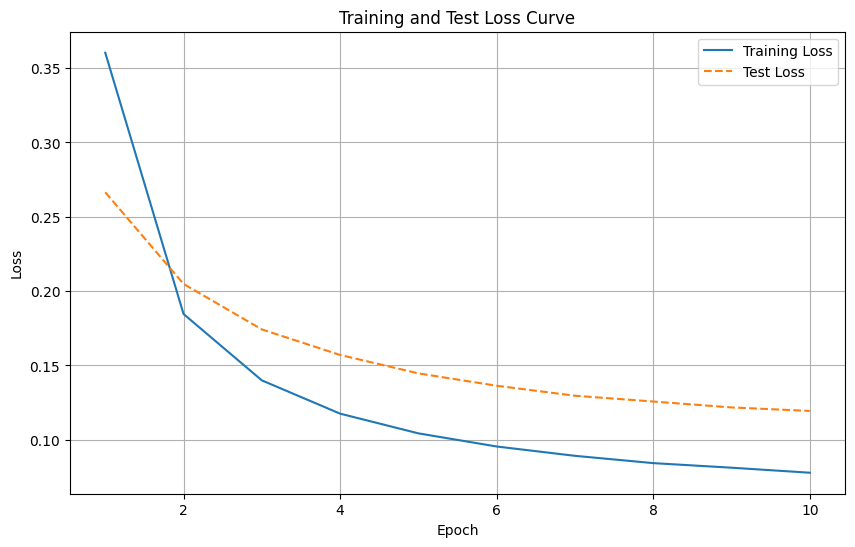

In [17]:
model_new_optimizer = ClassificationNet(input_units=30, hidden_units=64, output_units=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_new_optimizer.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001) # Here, change the optimizer to SGD

epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model_new_optimizer.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_new_optimizer(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model_new_optimizer.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model_new_optimizer(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## Change the number of neurons

Epoch [1/10], Train Loss: 0.2788, Test Loss: 0.1732
Epoch [2/10], Train Loss: 0.1072, Test Loss: 0.1249
Epoch [3/10], Train Loss: 0.0843, Test Loss: 0.1083
Epoch [4/10], Train Loss: 0.0733, Test Loss: 0.1045
Epoch [5/10], Train Loss: 0.0645, Test Loss: 0.0960
Epoch [6/10], Train Loss: 0.0575, Test Loss: 0.0923
Epoch [7/10], Train Loss: 0.0529, Test Loss: 0.0942
Epoch [8/10], Train Loss: 0.0491, Test Loss: 0.0932
Epoch [9/10], Train Loss: 0.0445, Test Loss: 0.0894
Epoch [10/10], Train Loss: 0.0404, Test Loss: 0.0960


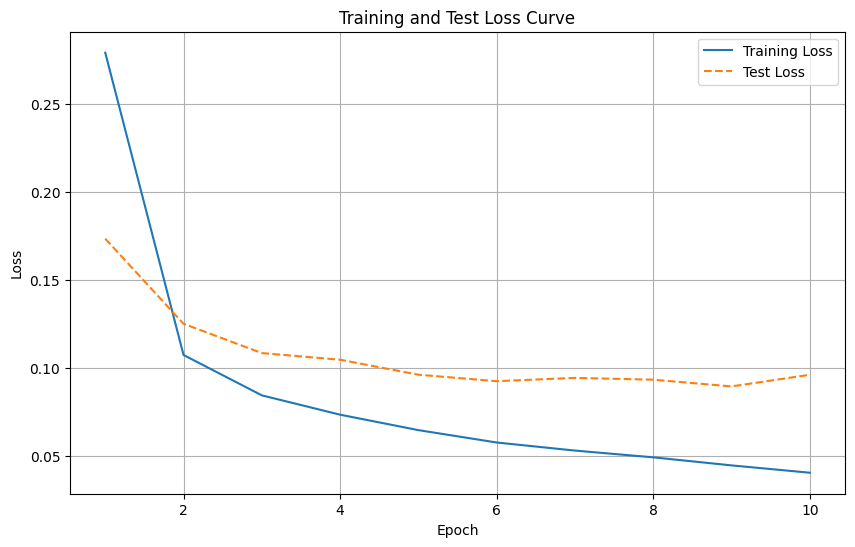

In [18]:
model_new = ClassificationNet(input_units=30, hidden_units=128, output_units=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new.parameters(), lr=0.001)

epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model_new.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_new(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model_new.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model_new(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## Different dataset - Iris Dataset

Epoch [1/10], Train Loss: 1.0769, Test Loss: 1.0336
Epoch [2/10], Train Loss: 0.9816, Test Loss: 0.9423
Epoch [3/10], Train Loss: 0.8874, Test Loss: 0.8619
Epoch [4/10], Train Loss: 0.8058, Test Loss: 0.7910
Epoch [5/10], Train Loss: 0.7409, Test Loss: 0.7293
Epoch [6/10], Train Loss: 0.6737, Test Loss: 0.6757
Epoch [7/10], Train Loss: 0.6259, Test Loss: 0.6297
Epoch [8/10], Train Loss: 0.5811, Test Loss: 0.5899
Epoch [9/10], Train Loss: 0.5359, Test Loss: 0.5559
Epoch [10/10], Train Loss: 0.5030, Test Loss: 0.5263


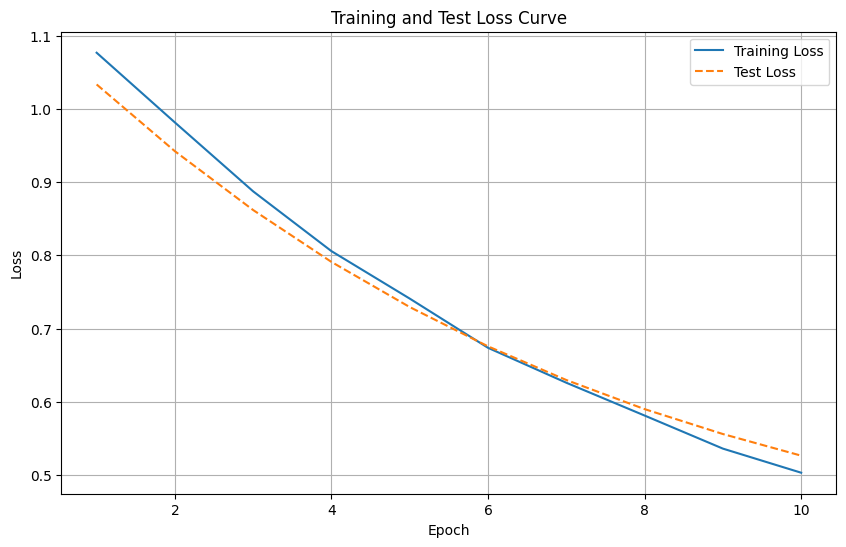

In [20]:
from sklearn.datasets import load_iris

iris = load_iris()
X_iris = iris.data
y_iris = iris.target

X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model_iris = ClassificationNet(input_units=4, hidden_units=128, output_units=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_iris.parameters(), lr=0.001)

epochs = 10
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model_iris.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_iris(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model_iris.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            test_outputs = model_iris(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()